In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import libraries and the file
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

#data = pd.read_csv('/content/drive/MyDrive/Group_Project/Project_Code/Copy of Redfin_pickle_new')

In [3]:
#read in pickle file
data = pd.read_pickle(r'/content/drive/MyDrive/Group_Project/Project_Code/Copy of Redfin_pickle_new')

In [4]:
OGdata = pd.read_csv('/content/drive/MyDrive/Group_Project/Project_Code/Copy of redfin_2022-11-03-08-46-51.csv')

In [5]:
OGdata.describe().apply(lambda s: s.apply('{0:,.2f}'.format)).T 

,count,mean,std,min,25%,50%,75%,max
ZIP OR POSTAL CODE,"10,000.00","15,211.95",11.82,"15,090.00","15,206.00","15,213.00","15,218.00","15,238.00"
PRICE,"9,712.00","332,278.62","577,794.52",1.00,"165,000.00","265,000.00","412,000.00","50,508,000.00"
BEDS,"9,672.00",3.14,1.38,0.00,2.00,3.00,4.00,24.00
BATHS,"9,536.00",2.01,0.97,0.50,1.00,2.00,2.50,12.00
SQUARE FEET,"7,255.00","1,820.38",958.13,0.00,"1,229.00","1,600.00","2,134.00","24,530.00"
LOT SIZE,"3,906.00","54,440.37","2,692,430.91",43.00,"1,742.00","2,740.00","4,356.00","165,310,200.00"
YEAR BUILT,"9,612.00","1,929.86",36.52,"1,620.00","1,900.00","1,920.00","1,950.00","2,022.00"
DAYS ON MARKET,0.00,nan,nan,nan,nan,nan,nan,nan
$/SQUARE FEET,"6,985.00",182.73,142.87,0.00,116.00,176.00,236.00,"8,800.00"
HOA/MONTH,"1,436.00",505.14,452.91,17.00,238.75,419.00,669.25,"8,037.00"


In [6]:
print("shape: ", OGdata.shape)
print("Type: ", OGdata.dtypes)


shape:  (10001, 27)
Type:  SALE TYPE                                                                                       object
SOLD DATE                                                                                       object
PROPERTY TYPE                                                                                   object
ADDRESS                                                                                         object
CITY                                                                                            object
STATE OR PROVINCE                                                                               object
ZIP OR POSTAL CODE                                                                             float64
PRICE                                                                                          float64
BEDS                                                                                           float64
BATHS                                         

In [7]:
def clean_redfin(redfin_data):
  clean_red = data.copy()
  # Clean redfin data
  # Only look at single family homes for now
  clean_red = clean_red[clean_red['PROPERTY TYPE'] == 'Single Family Residential']
  # Rename "Location" column to "Neighborhood"
  clean_red['Neighborhood'] = clean_red['LOCATION'].copy()
  # Combine location into one tuple
  clean_red['Location'] = list(zip(clean_red.LONGITUDE, clean_red.LATITUDE))
  # Drop unnecassary columns
  clean_red = clean_red.drop(columns = ['SALE TYPE', 'DAYS ON MARKET', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'SOURCE', 'FAVORITE', 'INTERESTED', 'PROPERTY TYPE',
                                      'ADDRESS', 'ZIP OR POSTAL CODE', 'HOA/MONTH', 'MLS#', 'CITY', 'STATE OR PROVINCE', '$/SQUARE FEET', 'LONGITUDE', 'LATITUDE', 'LOCATION'])
  # Eliminate rows missing sold date
  clean_red = clean_red[~clean_red['SOLD DATE'].isna()]
  # Eliminate or impute values with missing square footage values - eliminating for now - can impute later
  clean_red = clean_red[~clean_red['SQUARE FEET'].isna()]
  # Eliminate values without price
  clean_red = clean_red[~clean_red['PRICE'].isna()]
  # Eliminate or impute values without lot size
  clean_red = clean_red[~clean_red['LOT SIZE'].isna()]
  # Eliminate values without # Beds or # Baths (or impute with mode)
  clean_red = clean_red[~clean_red['BEDS'].isna()]
  clean_red = clean_red[~clean_red['BATHS'].isna()]
  # Eliminate values without neighborhood
  clean_red = clean_red[~clean_red['Neighborhood'].isna()]
  # Eliminate values without Year built
  clean_red = clean_red[~clean_red['YEAR BUILT'].isna()]
  # Extract Year Sold
  clean_red['Year'] = clean_red['SOLD DATE'].str.split("-").str[2]
  # Convert Year to integer
  clean_red['Year'] = clean_red['Year'].astype(int)
  # Extract Month Sold - convert to 1-12
  clean_red['Month'] = clean_red['SOLD DATE'].str.split("-").str[0]
  month_dict = {"January": 1, "February" : 2, "March" : 3, "April" : 4, "May" : 5, "June" : 6,
                "July" : 7, "August" : 8, "September" : 9, "October" : 10, "November" : 11, "December" : 12}
  clean_red.replace({'Month' : month_dict}, inplace=  True)
  # Drop Sold Date Column
  clean_red.drop(columns = 'SOLD DATE', inplace = True)
  # Create datetime columns
  clean_red['dt'] = pd.to_datetime(clean_red['Year'].astype(str) + clean_red['Month'].astype(str), format = '%Y%m')
  # Drop old Year and Month Columns
  clean_red.drop(columns = ['Year', 'Month'], inplace = True)
  return clean_red

In [8]:
#data = clean_redfin(data)

In [9]:
#data.columns
data = data.drop('Crime Score', axis=1)

In [10]:
data.describe().apply(lambda s: s.apply('{0:,.2f}'.format)).T 

,count,mean,std,min,25%,50%,75%,max
PRICE,"1,989.00","363,471.53","283,618.84","3,000.00","199,000.00","295,000.00","442,000.00","3,150,000.00"
BEDS,"1,989.00",3.36,1.10,0.00,3.00,3.00,4.00,10.00
BATHS,"1,989.00",2.03,0.95,0.50,1.50,2.00,2.50,7.50
SQUARE FEET,"1,989.00","1,868.54",916.72,100.00,"1,288.00","1,632.00","2,146.00","9,800.00"
LOT SIZE,"1,989.00","86,973.52","3,706,571.89",43.00,"1,742.00","2,857.00","4,356.00","165,310,200.00"
YEAR BUILT,"1,989.00","1,919.80",28.07,"1,620.00","1,900.00","1,915.00","1,930.00","2,022.00"


In [11]:
# check the shape of the DataFrame (rows, columns)
data.shape

(1989, 10)

In [12]:
#fill missing values with the means of the columns
data = data.fillna(data.mean())
data.head(10)

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),Neighborhood,Location,dt
2,275000.0,4.0,4.0,1785.0,1306.0,1900.0,https://www.redfin.com/PA/Pittsburgh/45-Greele...,South Side,"(-79.9743145, 40.4229551)",2021-10-01
3,302500.0,5.0,2.0,3034.0,2178.0,1900.0,https://www.redfin.com/PA/Pittsburgh/259-45th-...,Lawrenceville,"(-79.9576202, 40.4711406)",2021-06-01
4,301000.0,3.0,1.5,1972.0,1306.0,1890.0,https://www.redfin.com/PA/Pittsburgh/431-Taylo...,Bloomfield,"(-79.9523315, 40.4605557)",2021-10-01
9,379900.0,2.0,1.5,1226.0,1742.0,1890.0,https://www.redfin.com/PA/Pittsburgh/159-1-2-3...,Lawrenceville,"(-79.9655419, 40.4679636)",2021-09-01
11,390000.0,3.0,3.0,1519.0,2178.0,1910.0,https://www.redfin.com/PA/Pittsburgh/4919-Hatf...,Lawrenceville,"(-79.9573142, 40.4780842)",2020-12-01
14,612000.0,3.0,3.5,2460.0,2613.0,1920.0,https://www.redfin.com/PA/Pittsburgh/5208-Frie...,Friendship Park,"(-79.9398544, 40.4619007)",2021-07-01
16,299000.0,3.0,1.0,1557.0,2252.0,1906.0,https://www.redfin.com/PA/Pittsburgh/833-Flemi...,Greenfield,"(-79.9347259, 40.4264991)",2022-07-01
17,255000.0,3.0,1.5,1200.0,2674.0,1961.0,https://www.redfin.com/PA/Pittsburgh/1253-Love...,Squirrel Hill,"(-79.9023248, 40.4205813)",2022-05-01
22,295000.0,4.0,2.5,2236.0,1886.0,1991.0,https://www.redfin.com/PA/Pittsburgh/316-Lowel...,Lincoln-Larimer,"(-79.9118063, 40.4614483)",2022-05-01
24,277500.0,3.0,1.5,1455.0,1054.0,1900.0,https://www.redfin.com/PA/Pittsburgh/2009-Sara...,South Side,"(-79.9773405, 40.4278209)",2022-02-01


In [13]:
#I referenced https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

#add variables for year
data['yearSold'] = data['dt'].dt.year

#add variables for month
data['monthSold'] = data['dt'].dt.month


In [14]:
#explore data types
data.dtypes

PRICE                                                                                                 float64
BEDS                                                                                                  float64
BATHS                                                                                                 float64
SQUARE FEET                                                                                           float64
LOT SIZE                                                                                              float64
YEAR BUILT                                                                                            float64
URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)            object
Neighborhood                                                                                           object
Location                                                                                               object
dt        

In [15]:
data['yearSold'].unique()

array([2021, 2020, 2022, 2019, 2018, 2017])

In [16]:
#check collinearity
corr = data.corr()
corr.sort_values(['PRICE'], ascending = False, inplace = True)
print(corr.PRICE)

PRICE          1.000000
SQUARE FEET    0.752601
BATHS          0.725727
BEDS           0.514319
YEAR BUILT     0.130565
yearSold       0.091700
monthSold      0.044794
LOT SIZE       0.005424
Name: PRICE, dtype: float64


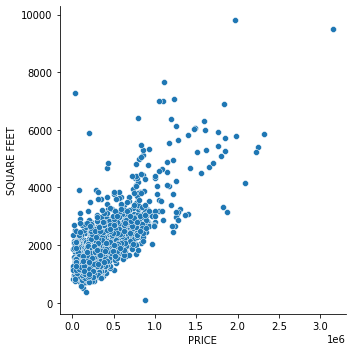

In [17]:
import seaborn as sns
sns.relplot(data=data, x="PRICE", y="SQUARE FEET")

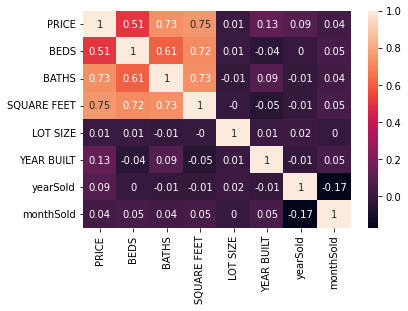

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

matrix = data.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

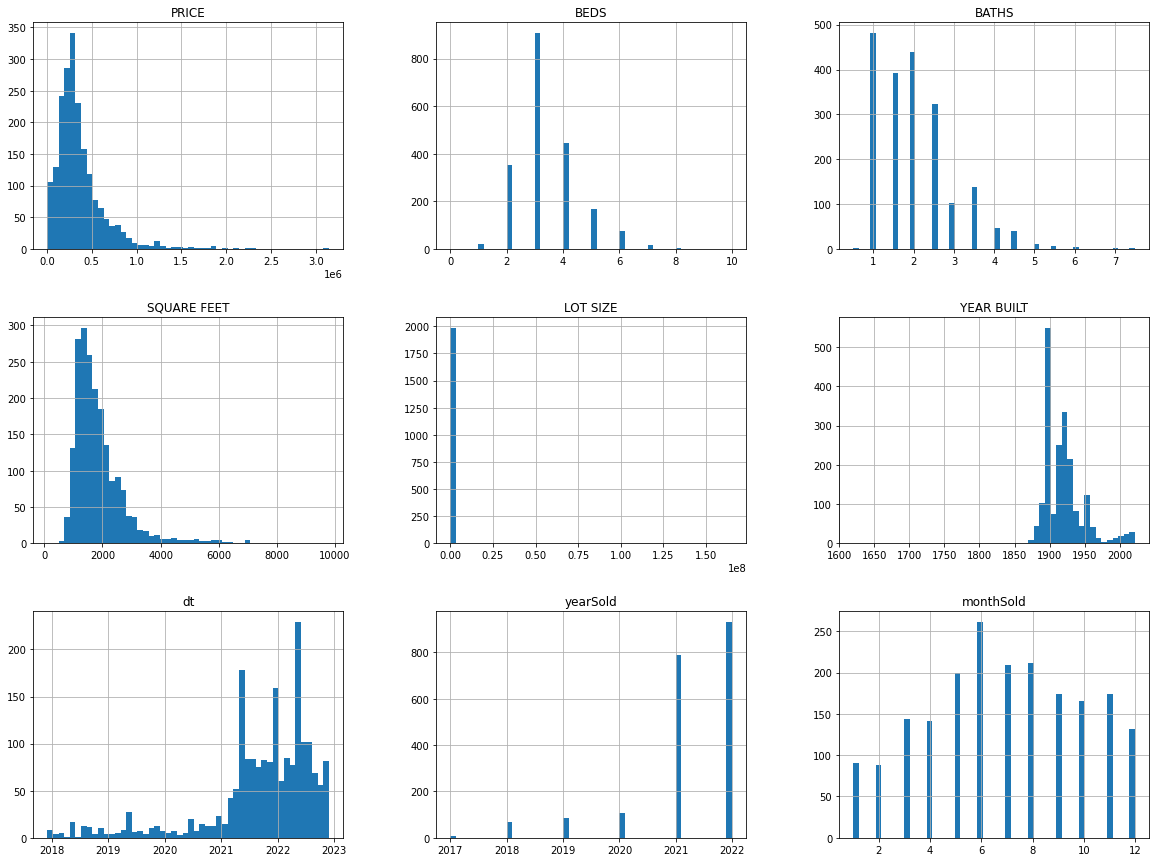

In [19]:
#visualize variables to see what needs to be scaled and what needs dummy variables
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [20]:
data.describe()

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,yearSold,monthSold
count,1.989000e+03,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000,1989.000000
mean,3.634715e+05,3.356461,2.032931,1868.541981,8.697352e+04,1919.804424,2021.212670,6.885872
std,2.836188e+05,1.101095,0.952755,916.721625,3.706572e+06,28.070127,1.002271,3.052285
min,3.000000e+03,0.000000,0.500000,100.000000,4.300000e+01,1620.000000,2017.000000,1.000000
25%,1.990000e+05,3.000000,1.500000,1288.000000,1.742000e+03,1900.000000,2021.000000,5.000000
50%,2.950000e+05,3.000000,2.000000,1632.000000,2.857000e+03,1915.000000,2021.000000,7.000000
75%,4.420000e+05,4.000000,2.500000,2146.000000,4.356000e+03,1930.000000,2022.000000,9.000000
max,3.150000e+06,10.000000,7.500000,9800.000000,1.653102e+08,2022.000000,2022.000000,12.000000


In [21]:
city_dummies = pd.get_dummies(data.Neighborhood, prefix='Neighborhood')

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, city_dummies], axis=1)

data.head(10)

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),Neighborhood,Location,dt,...,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg
2,275000.0,4.0,4.0,1785.0,1306.0,1900.0,https://www.redfin.com/PA/Pittsburgh/45-Greele...,South Side,"(-79.9743145, 40.4229551)",2021-10-01,...,0,1,0,0,0,0,0,0,0,0
3,302500.0,5.0,2.0,3034.0,2178.0,1900.0,https://www.redfin.com/PA/Pittsburgh/259-45th-...,Lawrenceville,"(-79.9576202, 40.4711406)",2021-06-01,...,0,0,0,0,0,0,0,0,0,0
4,301000.0,3.0,1.5,1972.0,1306.0,1890.0,https://www.redfin.com/PA/Pittsburgh/431-Taylo...,Bloomfield,"(-79.9523315, 40.4605557)",2021-10-01,...,0,0,0,0,0,0,0,0,0,0
9,379900.0,2.0,1.5,1226.0,1742.0,1890.0,https://www.redfin.com/PA/Pittsburgh/159-1-2-3...,Lawrenceville,"(-79.9655419, 40.4679636)",2021-09-01,...,0,0,0,0,0,0,0,0,0,0
11,390000.0,3.0,3.0,1519.0,2178.0,1910.0,https://www.redfin.com/PA/Pittsburgh/4919-Hatf...,Lawrenceville,"(-79.9573142, 40.4780842)",2020-12-01,...,0,0,0,0,0,0,0,0,0,0
14,612000.0,3.0,3.5,2460.0,2613.0,1920.0,https://www.redfin.com/PA/Pittsburgh/5208-Frie...,Friendship Park,"(-79.9398544, 40.4619007)",2021-07-01,...,0,0,0,0,0,0,0,0,0,0
16,299000.0,3.0,1.0,1557.0,2252.0,1906.0,https://www.redfin.com/PA/Pittsburgh/833-Flemi...,Greenfield,"(-79.9347259, 40.4264991)",2022-07-01,...,0,0,0,0,0,0,0,0,0,0
17,255000.0,3.0,1.5,1200.0,2674.0,1961.0,https://www.redfin.com/PA/Pittsburgh/1253-Love...,Squirrel Hill,"(-79.9023248, 40.4205813)",2022-05-01,...,0,0,0,0,0,1,0,0,0,0
22,295000.0,4.0,2.5,2236.0,1886.0,1991.0,https://www.redfin.com/PA/Pittsburgh/316-Lowel...,Lincoln-Larimer,"(-79.9118063, 40.4614483)",2022-05-01,...,0,0,0,0,0,0,0,0,0,0
24,277500.0,3.0,1.5,1455.0,1054.0,1900.0,https://www.redfin.com/PA/Pittsburgh/2009-Sara...,South Side,"(-79.9773405, 40.4278209)",2022-02-01,...,0,1,0,0,0,0,0,0,0,0


In [22]:
len(data['Neighborhood'].unique())

48

In [23]:
# Count the number of occurrences of each unique value in the "col" column
counts = data["Neighborhood"].value_counts()

# Print the counts
print(counts)


Lawrenceville         276
Squirrel Hill         249
South Side            186
Greenfield            136
Regent Square          93
Point Breeze           87
Highland Park          81
Shadyside              77
Stanton Heights        76
Bloomfield             76
Morningside            67
Troy Hill              57
East Liberty           56
Oakland                44
Garfield               44
Swissvale              42
Lincoln-Larimer        31
Sharpsburg             31
Friendship Park        30
Aspinwall              30
Hazelwood              27
Hill District          22
Polish Hill            19
Homewood-Brushton      19
Edgewood               19
Downtown Pgh           14
East Allegheny         13
Arlington              12
Wilkinsburg             8
Central North Side      7
Schenley Farms          7
Spring Garden           7
Schenley Heights        7
North of Forbes         5
Munhall                 5
Murdoch Farms           4
Allentown               4
Penn Hills              3
Mt Oliver   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text major ticklabel objects>)

<Figure size 720x576 with 0 Axes>

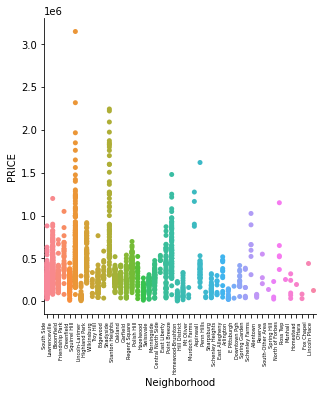

In [24]:
plt.figure(figsize=(10,8))
ax = sns.catplot(data=data, x="Neighborhood", y="PRICE", jitter=False)

plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=5  
)

In [25]:
data.describe()

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,yearSold,monthSold,Neighborhood_Allentown,Neighborhood_Arlington,...,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg
count,1.989000e+03,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,...,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,3.634715e+05,3.356461,2.032931,1868.541981,8.697352e+04,1919.804424,2021.212670,6.885872,0.002011,0.006033,...,0.015586,0.093514,0.000503,0.003519,0.001508,0.125189,0.038210,0.021116,0.028658,0.004022
std,2.836188e+05,1.101095,0.952755,916.721625,3.706572e+06,28.070127,1.002271,3.052285,0.044811,0.077458,...,0.123897,0.291225,0.022422,0.059235,0.038817,0.331016,0.191751,0.143808,0.166884,0.063308
min,3.000000e+03,0.000000,0.500000,100.000000,4.300000e+01,1620.000000,2017.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.990000e+05,3.000000,1.500000,1288.000000,1.742000e+03,1900.000000,2021.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.950000e+05,3.000000,2.000000,1632.000000,2.857000e+03,1915.000000,2021.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.420000e+05,4.000000,2.500000,2146.000000,4.356000e+03,1930.000000,2022.000000,9.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.150000e+06,10.000000,7.500000,9800.000000,1.653102e+08,2022.000000,2022.000000,12.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
print(data.columns.tolist())


['PRICE', 'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'Neighborhood', 'Location', 'dt', 'yearSold', 'monthSold', 'Neighborhood_Allentown', 'Neighborhood_Arlington', 'Neighborhood_Aspinwall', 'Neighborhood_Bloomfield', 'Neighborhood_Central North Side', 'Neighborhood_Downtown Pgh', 'Neighborhood_E Pittsburgh', 'Neighborhood_East Allegheny', 'Neighborhood_East Liberty', 'Neighborhood_Edgewood', 'Neighborhood_Fox Chapel', 'Neighborhood_Friendship Park', 'Neighborhood_Garfield', 'Neighborhood_Greenfield', 'Neighborhood_Hazelwood', 'Neighborhood_Highland Park', 'Neighborhood_Hill District', 'Neighborhood_Homestead', 'Neighborhood_Homewood-Brushton', 'Neighborhood_Lawrenceville', 'Neighborhood_Lincoln Place', 'Neighborhood_Lincoln-Larimer', 'Neighborhood_Morningside', 'Neighborhood_Mt Oliver', 'Neighborhood_Munhall', 'Neighborhood_Murdoch Farms', 'Neighborhood_North of Forbes', "Neigh

In [27]:
# create a Python list of feature names
feature_cols = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'yearSold', 'monthSold', 'Neighborhood_Allentown', 'Neighborhood_Arlington', 'Neighborhood_Aspinwall', 'Neighborhood_Bloomfield', 'Neighborhood_Central North Side', 'Neighborhood_Downtown Pgh', 'Neighborhood_E Pittsburgh', 'Neighborhood_East Allegheny', 'Neighborhood_East Liberty', 'Neighborhood_Edgewood', 'Neighborhood_Fox Chapel', 'Neighborhood_Friendship Park', 'Neighborhood_Garfield', 'Neighborhood_Greenfield', 'Neighborhood_Hazelwood', 'Neighborhood_Highland Park', 'Neighborhood_Hill District', 'Neighborhood_Homestead', 'Neighborhood_Homewood-Brushton', 'Neighborhood_Lawrenceville', 'Neighborhood_Lincoln Place', 'Neighborhood_Lincoln-Larimer', 'Neighborhood_Morningside', 'Neighborhood_Mt Oliver', 'Neighborhood_Munhall', 'Neighborhood_Murdoch Farms', 'Neighborhood_North of Forbes', "Neighborhood_O'Hara", 'Neighborhood_Oakland', 'Neighborhood_Penn Hills', 'Neighborhood_Point Breeze', 'Neighborhood_Polish Hill', 'Neighborhood_Regent Square', 'Neighborhood_Reserve', 'Neighborhood_Ross Twp', 'Neighborhood_Schenley Farms', 'Neighborhood_Schenley Heights', 'Neighborhood_Shadyside', 'Neighborhood_Sharpsburg', 'Neighborhood_South Side', 'Neighborhood_South-Other Area', 'Neighborhood_Spring Garden', 'Neighborhood_Spring Hill', 'Neighborhood_Squirrel Hill', 'Neighborhood_Stanton Heights', 'Neighborhood_Swissvale', 'Neighborhood_Troy Hill', 'Neighborhood_Wilkinsburg']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# print the first 5 rows
X.head()

,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,yearSold,monthSold,Neighborhood_Allentown,Neighborhood_Arlington,Neighborhood_Aspinwall,...,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg
2,4.0,4.0,1785.0,1306.0,1900.0,2021,10,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,5.0,2.0,3034.0,2178.0,1900.0,2021,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.5,1972.0,1306.0,1890.0,2021,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2.0,1.5,1226.0,1742.0,1890.0,2021,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,3.0,3.0,1519.0,2178.0,1910.0,2020,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(1989, 55)


In [29]:
print((data['Neighborhood'].unique()))

['South Side' 'Lawrenceville' 'Bloomfield' 'Friendship Park' 'Greenfield'
 'Squirrel Hill' 'Lincoln-Larimer' 'Highland Park' 'Wilkinsburg'
 'Troy Hill' 'Edgewood' 'Shadyside' 'Stanton Heights' 'Oakland' 'Garfield'
 'Regent Square' 'Polish Hill' 'Hazelwood' 'Swissvale' 'Morningside'
 'Central North Side' 'East Liberty' 'Point Breeze' 'Homewood-Brushton'
 'Hill District' 'Mt Oliver' 'Murdoch Farms' 'Aspinwall' 'Penn Hills'
 'Sharpsburg' 'Schenley Heights' 'East Allegheny' 'Arlington'
 'E Pittsburgh' 'Downtown Pgh' 'Spring Garden' 'Schenley Farms'
 'Allentown' 'Reserve' 'South-Other Area' 'Spring Hill' 'North of Forbes'
 'Ross Twp' 'Munhall' 'Homestead' "O'Hara" 'Fox Chapel' 'Lincoln Place']


In [30]:
# select a Series from the DataFrame
y = data['PRICE']

In [31]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(1989,)


Splitting into Training and Testing

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [33]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1491, 55)
(1491,)
(498, 55)
(498,)


Linear Regression

In [34]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression()

In [35]:
linreg.score(X_test, y_test)

0.7363173624225212

In [36]:
import statsmodels.api as sm

# Generate sample data for regression
X = X_test
y = y_test

# Fit a linear regression model to the data
model = sm.OLS(y, X)
#model = linreg.fit(X, y)
results = model.fit()

# Generate a standard regression table for the model
print(results.summary())
r().apply(lambda s: s.apply('{0:,.2f}'.format)).T 

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     32.37
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          6.14e-114
Time:                        18:21:06   Log-Likelihood:                -6572.8
No. Observations:                 498   AIC:                         1.324e+04
Df Residuals:                     452   BIC:                         1.343e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
BEDS      

In [38]:
# pair the feature names with the coefficients
mask = list(np.flip(np.argsort(linreg.coef_))[:5])
#[(feature_cols[i], linreg.coef_[i]) for i in mask]
#list(zip(feature_cols, linreg.coef_))[mask]
list(zip(feature_cols, linreg.coef_))


[('BEDS', -28143.036461916206),
 ('BATHS', 78009.44393822565),
 ('SQUARE FEET', 168.66938913057135),
 ('LOT SIZE', 0.00012677213817369193),
 ('YEAR BUILT', 1134.4293124448086),
 ('yearSold', 25262.927894450004),
 ('monthSold', 900.6357571788394),
 ('Neighborhood_Allentown', -133953.69579021062),
 ('Neighborhood_Arlington', -132308.8589790948),
 ('Neighborhood_Aspinwall', 84362.37810660715),
 ('Neighborhood_Bloomfield', 51551.26732715732),
 ('Neighborhood_Central North Side', 57538.10100725801),
 ('Neighborhood_Downtown Pgh', -48774.6806984215),
 ('Neighborhood_E Pittsburgh', -94954.15995653332),
 ('Neighborhood_East Allegheny', -24806.20762805923),
 ('Neighborhood_East Liberty', -25106.578510130275),
 ('Neighborhood_Edgewood', -12942.750003372981),
 ('Neighborhood_Fox Chapel', 1078.1155030807895),
 ('Neighborhood_Friendship Park', 43042.74010259908),
 ('Neighborhood_Garfield', -3349.173224968786),
 ('Neighborhood_Greenfield', 22190.699084071755),
 ('Neighborhood_Hazelwood', -112499.133

In [39]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [40]:
linreg.fit(X_train, y_train)
print('Liner Regression R squared: %.4f' % linreg.score(X_test, y_test))

Liner Regression R squared: 0.7363


In [41]:
# calculate MSE using scikit-learn
print('Linear Regression MSE: %.4f' % metrics.mean_squared_error(y_test, y_pred))

Linear Regression MSE: 18975841807.8837


In [42]:
# calculate RMSE using scikit-learn
print('Linear Regression RMSE: %.4f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression RMSE: 137752.8287


In [43]:
from sklearn.metrics import mean_absolute_error

print("Linear Regression MAE: ",mean_absolute_error(y_true=y_test,y_pred=y_pred))

Linear Regression MAE:  93381.02508633002



 Redfin Linear Regression  results  Test 

RMSE:  137,752.83
MAE:   93,381.03
R^2:   0.74



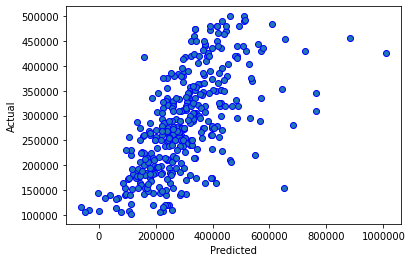

In [44]:
from sklearn.metrics import mean_squared_error

# function that computes the error metrics 

def computeMetricsForRegression(model_name, model_name_string,test_type, y_type): 
    
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    R2 = linreg.score(X_test, y_test)
    
    print('\n',model_name_string,' results ', test_type, '\n')
    print("RMSE: ", f"{RMSE:,.2f}")
    print("MAE:  ", f"{MAE:,.2f}")
    print("R^2:  ", f"{R2:,.2f}")
    print()
    
    # source: https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
    fig, ax = plt.subplots()
    ax.scatter(model_name, y_type, edgecolors=(0, 0, 1))
#     ax.plot([y_type.min(), y_type.max()], [y_type.min(), y_type.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.ticklabel_format(style='plain')
    plt.show()
# limit results to feasible range
pred_test_gbr= y_pred

yHat = pd.DataFrame(pred_test_gbr, columns=['yHat'])

yActual = pd.DataFrame(y_test)
yActual.rename(columns={'PRICE':'yActual'}, inplace = True)

yHat.reset_index(inplace=True, drop=True)
yActual.reset_index(inplace=True, drop=True)

testResults = pd.concat([yHat, yActual], axis=1)

testResultsLimited = testResults.loc[(testResults['yActual'] > 100000) & (testResults['yActual'] < 500000)]

computeMetricsForRegression(testResultsLimited['yHat'], 'Redfin Linear Regression','Test', testResultsLimited['yActual'])

In [45]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Text(0.5, 1.0, 'Redfin Linear Regression Model')

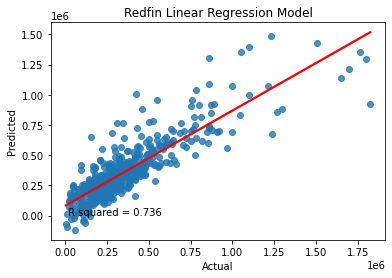

In [46]:
#https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot
#create basic scatterplot
sns.regplot(y_test, y_pred, ci=None, line_kws={"color": "red"})
plt.annotate(" R squared = {:.3f}".format(r2_score(y_test, y_pred)), (0, 1))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Redfin Linear Regression Model")

In [47]:
#run random forest
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [48]:
# make predictions on the testing set
y_pred2 = rf.predict(X_test)

In [49]:
rf.fit(X_train, y_train)
print('Random Forest R squared: %.4f' % rf.score(X_test, y_test))

Random Forest R squared: 0.7471


In [50]:
# calculate MSE using scikit-learn
print('Random Forest MSE: %.4f' % metrics.mean_squared_error(y_test, y_pred))

Random Forest MSE: 18975841807.8837


In [51]:
# calculate RMSE using scikit-learn
print('Random Forest RMSE: %.4f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Random Forest RMSE: 137752.8287


Text(0.5, 1.0, 'Redfin Random Forest Model')

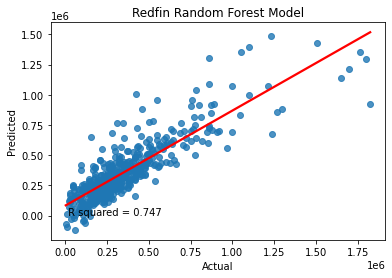

In [52]:
#https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot
#create basic scatterplot
sns.regplot(y_test, y_pred, ci=None, line_kws={"color": "red"})
plt.annotate(" R squared = {:.3f}".format(r2_score(y_test, y_pred2)), (0, 1))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Redfin Random Forest Model")